In [60]:
from dataset_loader import DatasetLoader
import matplotlib.pyplot as plt

In [61]:
writers = ["gpt", "plan_write", "s2s", "gpt_kg", "fusion"]
path = "meva/mans_wp.json"
loader = DatasetLoader("meva", path, writers)
prompt2Idx, idx2Prompt, prompt2Scores, prompt2Stories = loader.process_data()
print(len(prompt2Idx), len(idx2Prompt), len(prompt2Scores), len(prompt2Stories))

story_length = 0
num_stories = 0
for prompt in prompt2Stories:
    for writer in prompt2Stories[prompt]:
        num_stories += 1
        story = prompt2Stories[prompt][writer]
        story_length += len(story.split())

assert num_stories == 1000
ave_story_length = story_length / num_stories

print("Meva average story length: ", ave_story_length)

meva data loaded from local successfully.

200 200 200 200
Meva average story length:  229.115


Meva max score:  25
Meva min score:  5 

Meva max score:  5.0
Meva min score:  1.0 

Meva average score for gpt: 3.111999999999999
Meva average score for plan_write: 2.5769999999999986
Meva average score for s2s: 2.484
Meva average score for gpt_kg: 3.1789999999999994
Meva average score for fusion: 2.704


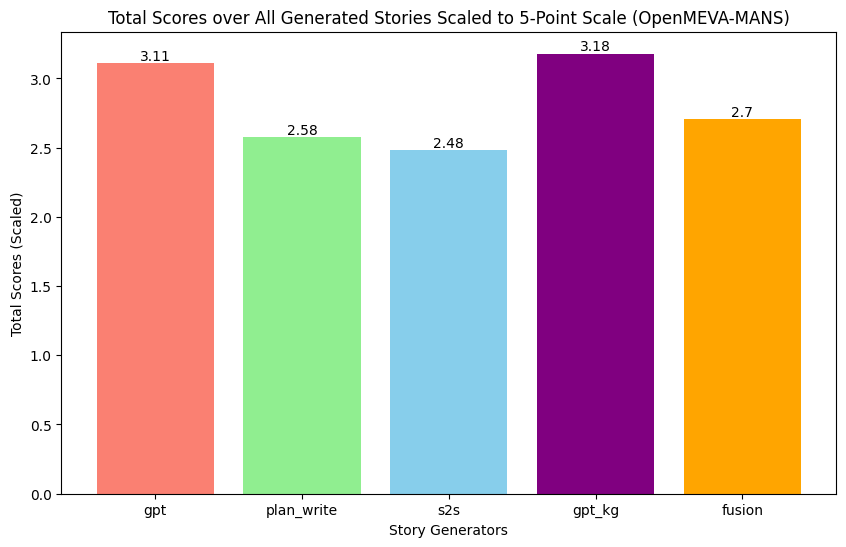

In [62]:
max_score = 0
min_score = 10000
for prompt in prompt2Stories:
    for writer in prompt2Stories[prompt]:
        score = prompt2Scores[prompt][writer]
        max_score = max(max_score, score)
        min_score = min(min_score, score)

print("Meva max score: ", max_score)
print("Meva min score: ", min_score, "\n")

max_score = 0
min_score = 10000
for prompt in prompt2Stories:
    for writer in writers:
        prompt2Scores[prompt][writer] /= 5
        score = prompt2Scores[prompt][writer]
        max_score = max(max_score, score)
        min_score = min(min_score, score)

print("Meva max score: ", max_score)
print("Meva min score: ", min_score, "\n")

writer_scores = {writer: 0 for writer in writers}
for writer in writers:
    for prompt in prompt2Scores:
        writer_scores[writer] += prompt2Scores[prompt][writer]
    assert len(prompt2Scores) == 200
    writer_scores[writer] /= len(prompt2Scores)

for writer in writers:
    print(f"Meva average score for {writer}: {writer_scores[writer]}")

# Plot the average scores per writer
scores = [writer_scores[writer] for writer in writers]

# Creating the bar graph
plt.figure(figsize=(10, 6))
colors = ['salmon', 'lightgreen', 'skyblue', 'purple', 'orange', 'gold', 'pink', 'lightgrey', 'cyan', 'olive']
bars = plt.bar(writers, scores, color=colors)

# Adding the numeric score on the corresponding bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Adding labels and title
plt.xlabel('Story Generators')
plt.ylabel('Total Scores (Scaled)')
plt.title('Total Scores over All Generated Stories Scaled to 5-Point Scale (OpenMEVA-MANS)')

# Display the plot
plt.show()

In [64]:
writers = ["Human", "BertGeneration", "CTRL", "GPT", "GPT-2 (tag)", "GPT-2", "RoBERTa", "XLNet", "Fusion", "HINT", "TD-VAE"]
path = "hanna/hanna_stories_annotations.csv"
loader = DatasetLoader("hanna", path, writers)
prompt2Idx, idx2Prompt, prompt2Scores, prompt2Stories = loader.process_data()
print(len(prompt2Idx), len(idx2Prompt), len(prompt2Scores), len(prompt2Stories))

writers = ["BertGeneration", "CTRL", "GPT", "GPT-2 (tag)", "GPT-2", "RoBERTa", "XLNet", "Fusion", "HINT", "TD-VAE"]
story_length = 0
num_stories = 0
for prompt in prompt2Stories:
    for writer in writers:
        num_stories += 1
        story = prompt2Stories[prompt][writer]
        story_length += len(story.split())

assert num_stories == 960
ave_story_length = story_length / num_stories

print("Hanna average story length: ", ave_story_length)

hanna data loaded from local successfully.

96 96 96 96
Hanna average story length:  228.740625


Hanna max score:  84
Hanna min score:  18 

Hanna max score:  4.166666666666667
Hanna min score:  1.0 

Hanna average score for BertGeneration: 2.5092592592592586
Hanna average score for CTRL: 2.4033564814814823
Hanna average score for GPT: 2.561342592592594
Hanna average score for GPT-2 (tag): 2.7309027777777786
Hanna average score for GPT-2: 2.719328703703704
Hanna average score for RoBERTa: 2.5497685185185195
Hanna average score for XLNet: 2.3576388888888897
Hanna average score for Fusion: 2.1429398148148144
Hanna average score for HINT: 1.8616898148148149
Hanna average score for TD-VAE: 2.4577546296296298


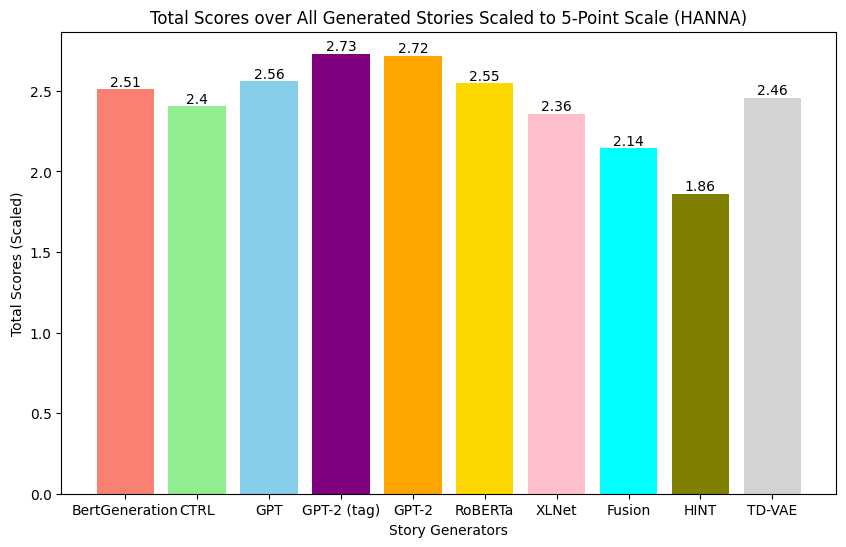

In [65]:
max_score = 0
min_score = 10000
for prompt in prompt2Stories:
    for writer in prompt2Stories[prompt]:
        score = prompt2Scores[prompt][writer]
        max_score = max(max_score, score)
        min_score = min(min_score, score)

print("Hanna max score: ", max_score)
print("Hanna min score: ", min_score, "\n")

max_score = 0
min_score = 10000
for prompt in prompt2Stories:
    for writer in writers:
        prompt2Scores[prompt][writer] /= 18
        score = prompt2Scores[prompt][writer]
        max_score = max(max_score, score)
        min_score = min(min_score, score)

print("Hanna max score: ", max_score)
print("Hanna min score: ", min_score, "\n")

writer_scores = {writer: 0 for writer in writers}
for writer in writers:
    for prompt in prompt2Scores:
        writer_scores[writer] += prompt2Scores[prompt][writer]
    assert len(prompt2Scores) == 96
    writer_scores[writer] /= len(prompt2Scores)

for writer in writers:
    print(f"Hanna average score for {writer}: {writer_scores[writer]}")

# Plot the average scores per writer
scores = [writer_scores[writer] for writer in writers]

# Creating the bar graph
plt.figure(figsize=(10, 6))
colors = ['salmon', 'lightgreen', 'skyblue', 'purple', 'orange', 'gold', 'pink', 'cyan', 'lightgrey', 'olive']
bars = plt.bar(writers, scores, color=colors)

# Adding the numeric score on the corresponding bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Adding labels and title
plt.xlabel('Story Generators')
plt.ylabel('Total Scores (Scaled)')
plt.title('Total Scores over All Generated Stories Scaled to 5-Point Scale (HANNA)')

# Display the plot
plt.show()